In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
from datetime import timedelta, date, datetime
import time

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv
Saving Global DataBase3.csv to Global DataBase3.csv


In [3]:
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True, dayfirst = True)

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst = True)

columns = ['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns : 
    df[column] = df2[column].resample("D").mean()

columns = ['Electricity Consumption (MWh)']
for column in columns : 
    df[column] = df2[column].resample("D").sum()
    
df = df.sort_index()


#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()

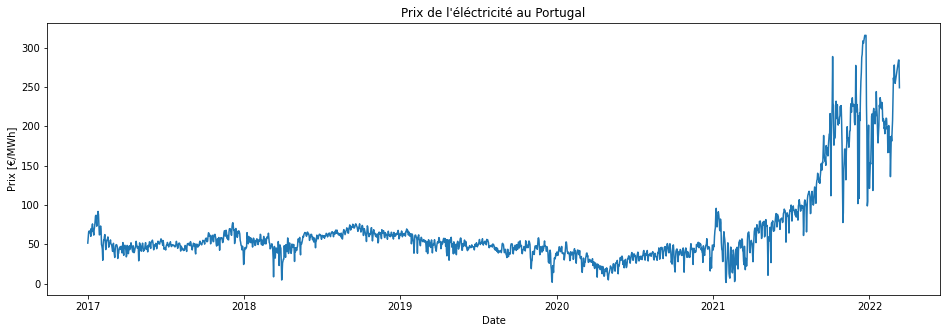

In [4]:
#Plot Price after data cleaning
plt.figure(figsize=(16,5))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Prix [€/MWh]')
plt.plot(df.index, df['Price - PT [€/MWh]'])  
plt.show()

In [5]:
df_u=df[['Price - PT [€/MWh]']].dropna()
df_u

,Price - PT [€/MWh]
datetime_per_day,
2017-01-01,51.421739
2017-01-02,58.878333
2017-01-03,65.245833
2017-01-04,66.700417
2017-01-05,66.858750
...,...
2022-03-01,259.459167
2022-03-02,254.469583
2022-03-10,284.066667


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_u.values)
    
reframed= series_to_supervised(scaled, 36)
reframed

,var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
36,-0.681567,-0.634080,-0.593530,-0.584266,-0.583258,-0.598120,-0.591375,-0.626863,-0.564145,-0.589300,...,-0.615050,-0.612561,-0.558886,-0.543254,-0.563328,-0.691982,-0.707065,-0.729914,-0.820364,-0.693551
37,-0.634080,-0.593530,-0.584266,-0.583258,-0.598120,-0.591375,-0.626863,-0.564145,-0.589300,-0.549590,...,-0.612561,-0.558886,-0.543254,-0.563328,-0.691982,-0.707065,-0.729914,-0.820364,-0.693551,-0.657596
38,-0.593530,-0.584266,-0.583258,-0.598120,-0.591375,-0.626863,-0.564145,-0.589300,-0.549590,-0.526155,...,-0.558886,-0.543254,-0.563328,-0.691982,-0.707065,-0.729914,-0.820364,-0.693551,-0.657596,-0.658678
39,-0.584266,-0.583258,-0.598120,-0.591375,-0.626863,-0.564145,-0.589300,-0.549590,-0.526155,-0.579310,...,-0.543254,-0.563328,-0.691982,-0.707065,-0.729914,-0.820364,-0.693551,-0.657596,-0.658678,-0.625040
40,-0.583258,-0.598120,-0.591375,-0.626863,-0.564145,-0.589300,-0.549590,-0.526155,-0.579310,-0.592543,...,-0.563328,-0.691982,-0.707065,-0.729914,-0.820364,-0.693551,-0.657596,-0.658678,-0.625040,-0.612659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,0.433731,0.419147,0.495664,0.472650,0.422393,0.406151,0.457379,0.430173,0.306217,0.326073,...,0.026090,0.182143,0.143935,0.229903,0.312066,0.492272,0.655863,0.621638,0.759938,0.643296
1884,0.419147,0.495664,0.472650,0.422393,0.406151,0.457379,0.430173,0.306217,0.326073,0.320260,...,0.182143,0.143935,0.229903,0.312066,0.492272,0.655863,0.621638,0.759938,0.643296,0.611520
1885,0.495664,0.472650,0.422393,0.406151,0.457379,0.430173,0.306217,0.326073,0.320260,0.247623,...,0.143935,0.229903,0.312066,0.492272,0.655863,0.621638,0.759938,0.643296,0.611520,0.800006
1886,0.472650,0.422393,0.406151,0.457379,0.430173,0.306217,0.326073,0.320260,0.247623,0.253673,...,0.229903,0.312066,0.492272,0.655863,0.621638,0.759938,0.643296,0.611520,0.800006,0.800006


In [8]:
#values = reframed_differenced.values
values = reframed.values
n_train_days=  int(len(values) * 0.5)
n_val_days= int(len(values) * 0.75)
train = values[:n_train_days, :]
val= values[n_train_days:n_val_days, :]
test = values[n_val_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(test_X)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(test_X)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

index_test=df_u['Price - PT [€/MWh]'][n_val_days:]

[[-0.77670046 -0.72531023 -0.72125303 ... -0.69220523 -0.71049842
  -0.70856402]
 [-0.72531023 -0.72125303 -0.80363078 ... -0.71049842 -0.70856402
  -0.70317743]
 [-0.72125303 -0.80363078 -0.91696419 ... -0.70856402 -0.70317743
  -0.67484076]
 ...
 [ 0.49566353  0.47264977  0.42239258 ...  0.75993833  0.64329601
   0.61152041]
 [ 0.47264977  0.42239258  0.40615054 ...  0.64329601  0.61152041
   0.8000061 ]
 [ 0.42239258  0.40615054  0.4573789  ...  0.61152041  0.8000061
   0.8000061 ]]
[[[-0.77670046 -0.72531023 -0.72125303 ... -0.69220523 -0.71049842
   -0.70856402]]

 [[-0.72531023 -0.72125303 -0.80363078 ... -0.71049842 -0.70856402
   -0.70317743]]

 [[-0.72125303 -0.80363078 -0.91696419 ... -0.70856402 -0.70317743
   -0.67484076]]

 ...

 [[ 0.49566353  0.47264977  0.42239258 ...  0.75993833  0.64329601
    0.61152041]]

 [[ 0.47264977  0.42239258  0.40615054 ...  0.64329601  0.61152041
    0.8000061 ]]

 [[ 0.42239258  0.40615054  0.4573789  ...  0.61152041  0.8000061
    0.800006

In [9]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [10]:
# fit network
start_time=time.time()
history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(val_X, val_y), verbose=0, shuffle=False)
exec_time= time.time()-start_time

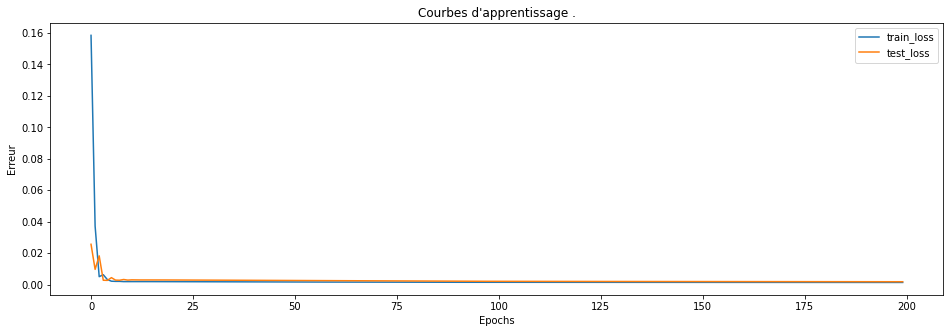

In [11]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [12]:
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
#Transform test to be 2D
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

(463, 1, 36)


In [13]:
test_X=pd.DataFrame(test_X)
# invert scaling for forecast
test_X[0]= yhat
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [14]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]= test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [15]:
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 16.669886459535334
Mean Squared Error: 662.599505328668
Root Mean Squared Error: 25.741008242271086
Coefficient of Variance: 21.72832362417979
R2: 0.8803125154641629
exec_time: 19.13785719871521


[Text(0, 0.5, 'Price [€/MWh]'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, "Prix de l'éléctricité au Portugal")]

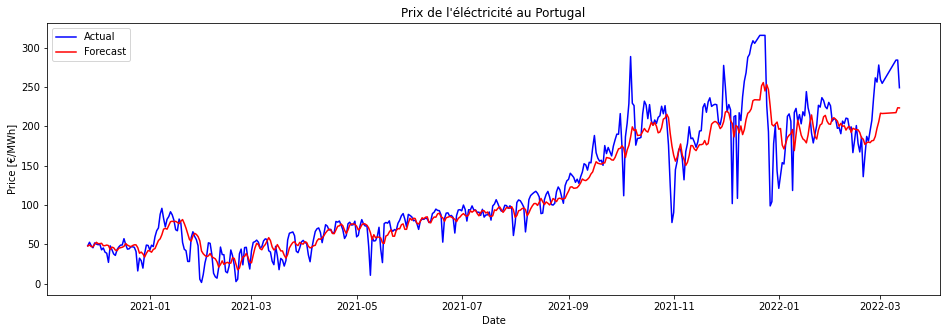

In [16]:
plt.figure(figsize=(16,5))
plt.plot(index_test[36:].index, inv_y, color='blue')
plt.plot(index_test[36:].index, inv_yhat, color='red')
plt.legend(('Actual', 'Forecast'))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Price [€/MWh]')

In [ ]:
# BEST n_in

score = []
best_n = 28
best_score = 0

for n in range(best_n, 60):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled = scaler.fit_transform(df_u.values)
  reframed= series_to_supervised(scaled, n)
  
  #values = reframed_differenced.values
  values = reframed.values
  n_train_days=  int(len(values) * 0.5)
  n_val_days= int(len(values) * 0.75)
  train = values[:n_train_days, :]
  val= values[n_train_days:n_val_days, :]
  test = values[n_val_days:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  val_X, val_y = val[:, :-1], val[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  index_test=df_u['Price - PT [€/MWh]'][n_val_days:]
    # design network
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  start_time=time.time()
  history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(val_X, val_y), verbose=0, shuffle=False)
  exec_time= time.time()-start_time
  # make a prediction
  
  yhat = model.predict(test_X)
  #Transform test to be 2D
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  test_X=pd.DataFrame(test_X)
  # invert scaling for forecast
  test_X[0]= yhat
  inv_yhat = scaler.inverse_transform(test_X)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  test_X[0]= test_y
  inv_y = scaler.inverse_transform(test_X)
  inv_y = inv_y[:,0]
  #Calculate MAE, MSE, RMSE, CV
  MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
  MSE=metrics.mean_squared_error(inv_y, inv_yhat)
  CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
  R2= metrics.r2_score(inv_y, inv_yhat)
  print(n)

  print('Mean Absolute Error:', MAE)
  print('Mean Squared Error:', MSE)  
  print('Root Mean Squared Error:', np.sqrt(MSE))
  print('Coefficient of Variance:',CV)
  print('R2:', R2)
  print('exec_time:', exec_time)
  print("*************************")



  if best_score < R2:
        best_n = n
print('best_n' , best_n)